# Simple regression with bayesian neural networks

In this notebook you will find a comparison between two bayesian methods to assess uncertainty when dealing with neural networks: **Monte-Carlo Dropout** (["Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)) and **Bayesian by Backpropagation** (["Weight Uncertainty in Neural Networks"](https://arxiv.org/abs/1505.05424)). We study a very simple toy regression model in 1D.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import torch
from torch.utils import data

## 0. Data preparation

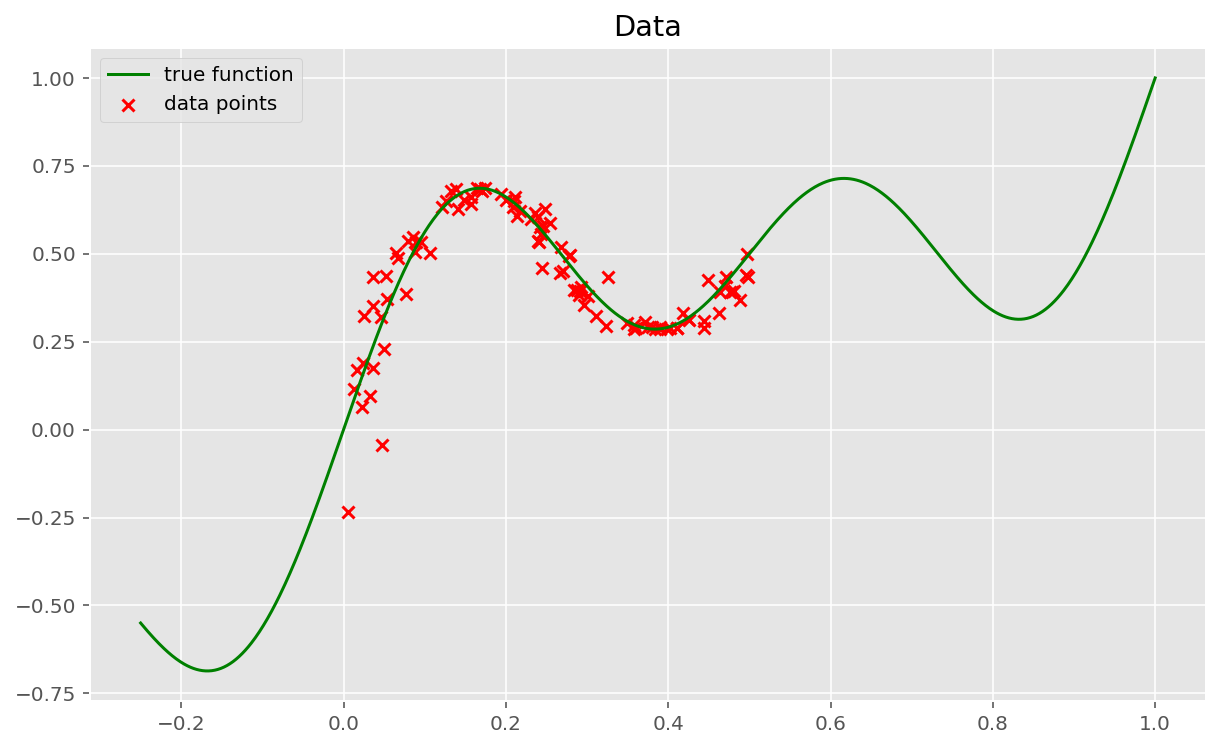

In [2]:
N = 100  #number of training data points
sigma = 0.02
dataset = {}

def function(x, epsilon):
    return x + 0.3 * np.sin(2 * np.pi * (x + epsilon)) + 0.3 * np.sin(4 * np.pi * (x + epsilon)) + epsilon

dataset['X_train'] = np.random.uniform(0, 0.5, N)
dataset['y_train'] = function(dataset['X_train'], np.random.normal(0, sigma, N))

dataset['X_test'] = np.linspace(-0.25, 1, 1000)
F = function(dataset['X_test'], 0)

plt.figure(figsize=(10, 6))
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.scatter(dataset['X_train'], dataset['y_train'], marker='x', color='red', label='data points')
plt.legend()
plt.title("Data")
plt.show()

In [3]:
X_train_tensor = torch.from_numpy(dataset['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset['X_test'].copy()).float().unsqueeze(dim=1)

## 1. Deterministic regression

In [468]:
import models.deterministic_regression as dreg

##### Definition of the model

In [469]:
net = dreg.DeterministicNet(hidden_size=100, dim_input=1, dim_output=1)
reg_model = dreg.DeterministicReg(X_train_tensor, y_train_tensor, X_test_tensor, net)

##### Training step

In [470]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion, batch=False)

##### Test step

In [471]:
y_pred = reg_model.predict()

##### Plot results

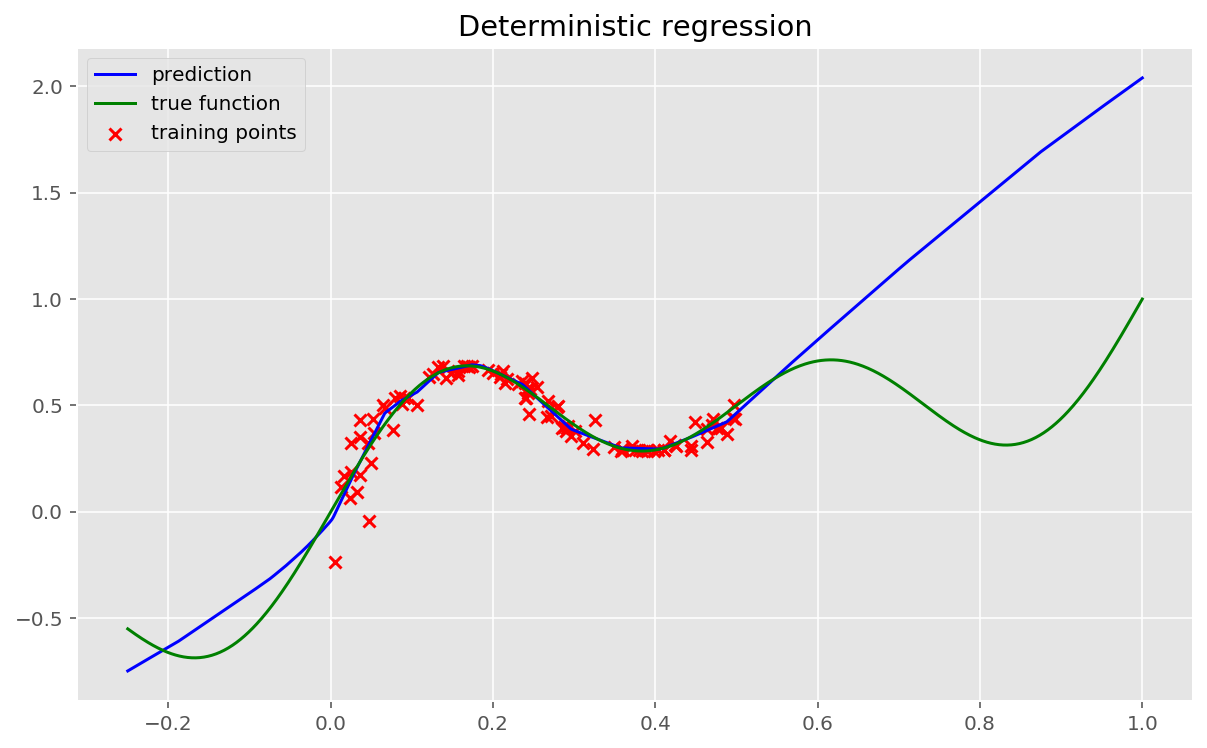

In [472]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title('Deterministic regression')
plt.show()

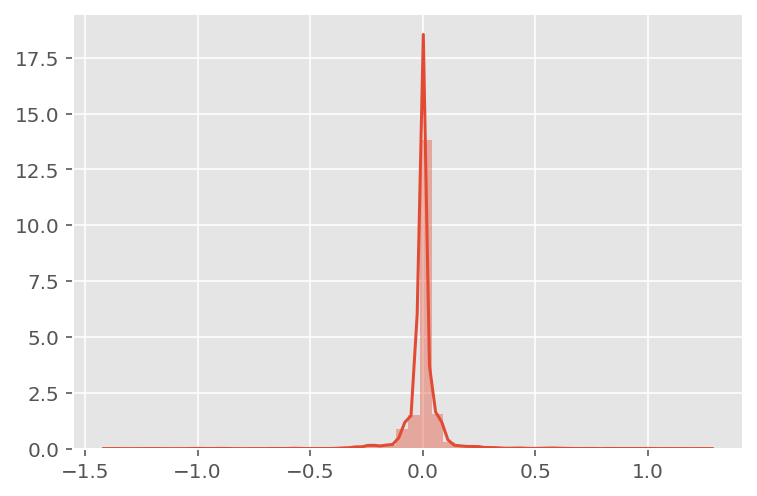

In [473]:
sns.distplot(net.weights_dist())

## 2. Bayesian regression with Monte-Carlo dropout

In [474]:
import models.dropout_regression as doreg

##### Definition of the model

In [475]:
net = doreg.DropoutNet(hidden_size=100, dim_input=1, dim_output=1, p=0.25)
reg_model = doreg.DropoutReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=X_train_tensor.shape[0])

##### Training step

In [476]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion)

##### Test step

In [477]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

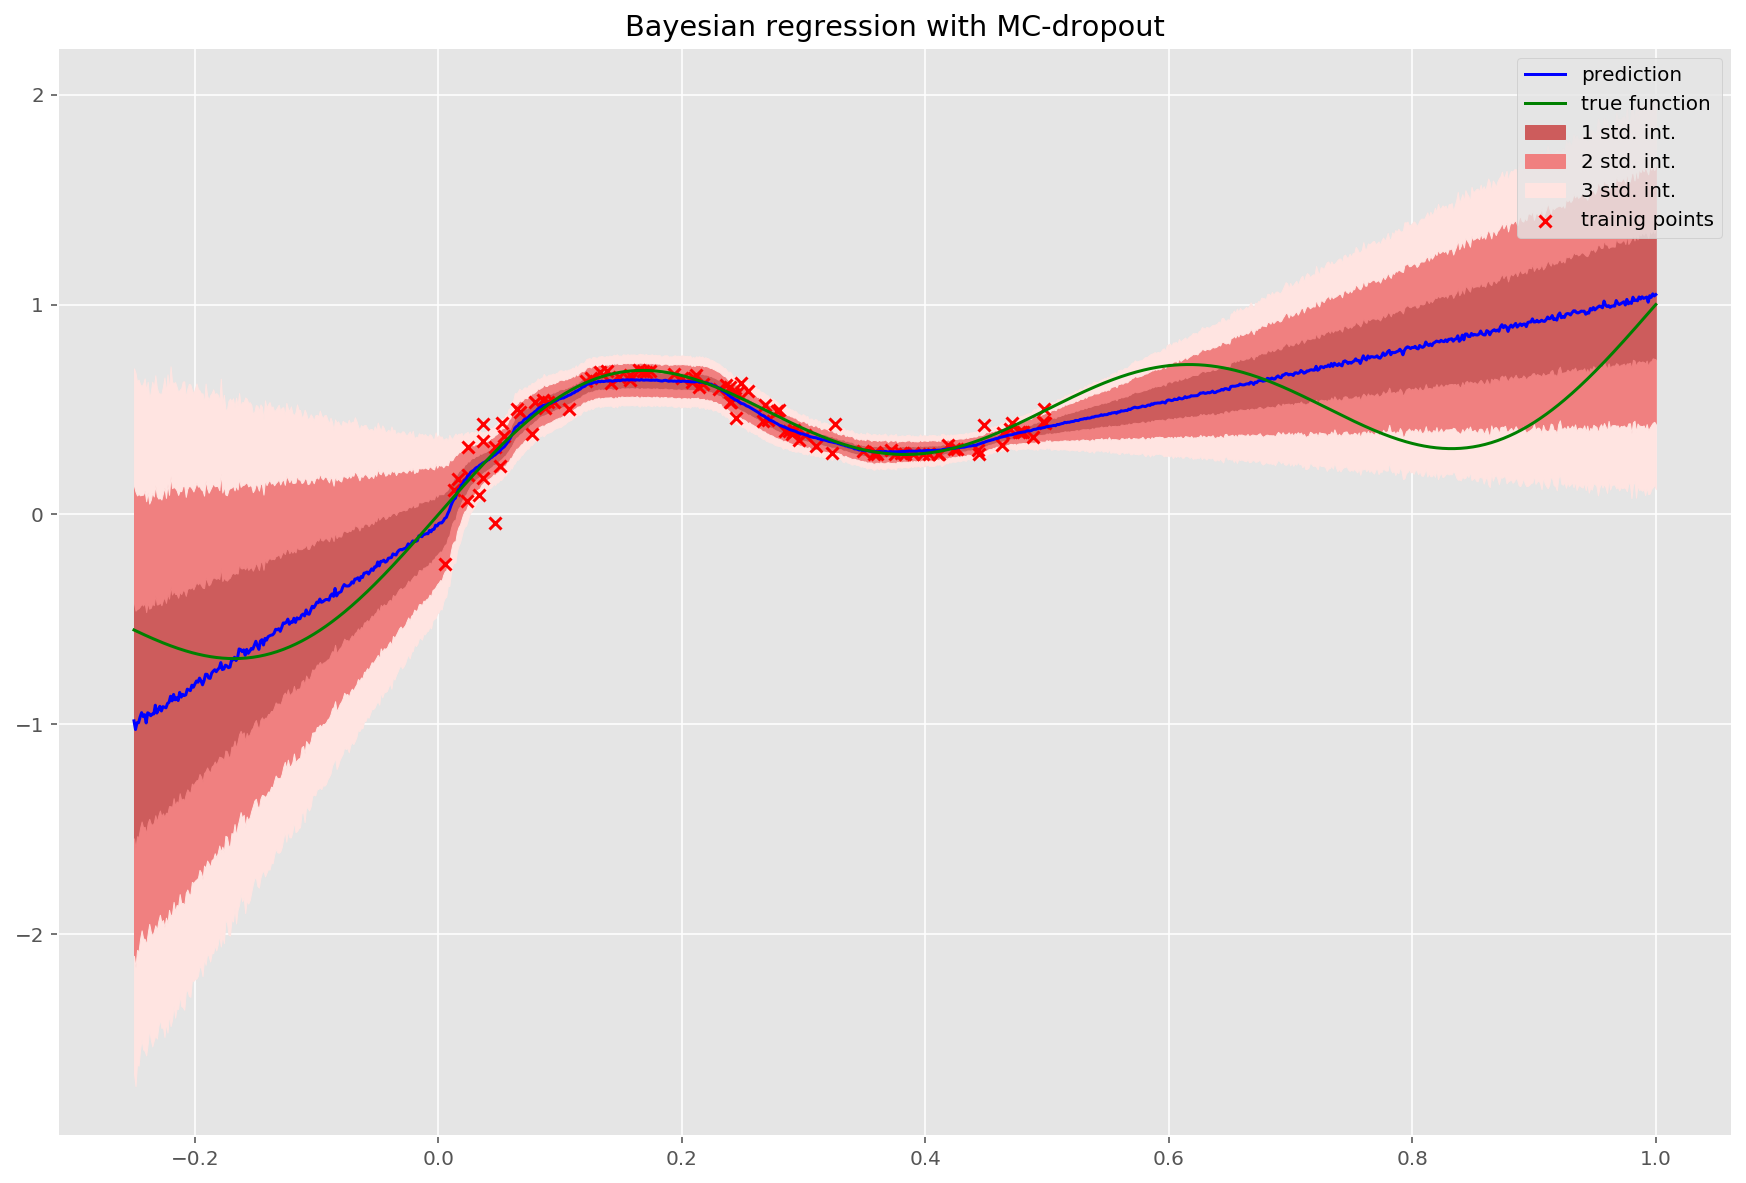

In [478]:
plt.figure(figsize=(15, 10))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title("Bayesian regression with MC-dropout")
plt.show()

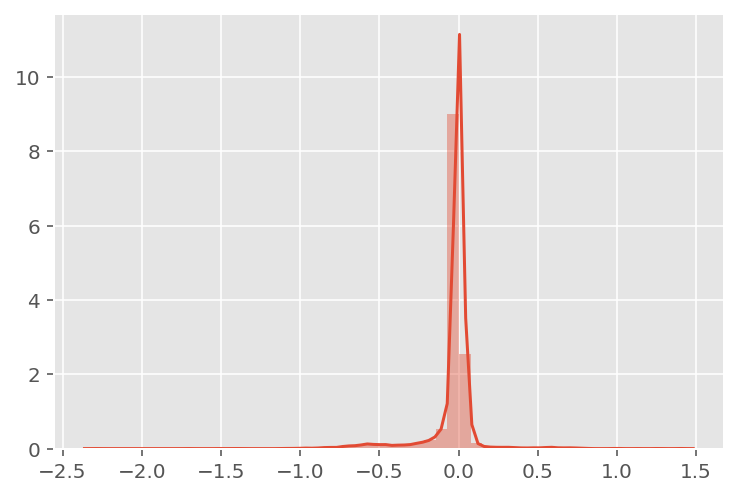

In [479]:
sns.distplot(net.weights_dist())
plt.show()

In [480]:
def log_likelihood(y, output, sigma=0.06):
    return torch.sum(-0.5 * np.log(2 * np.pi * sigma ** 2) - 0.5 * (y.squeeze() - output.squeeze()) ** 2 / sigma ** 2)

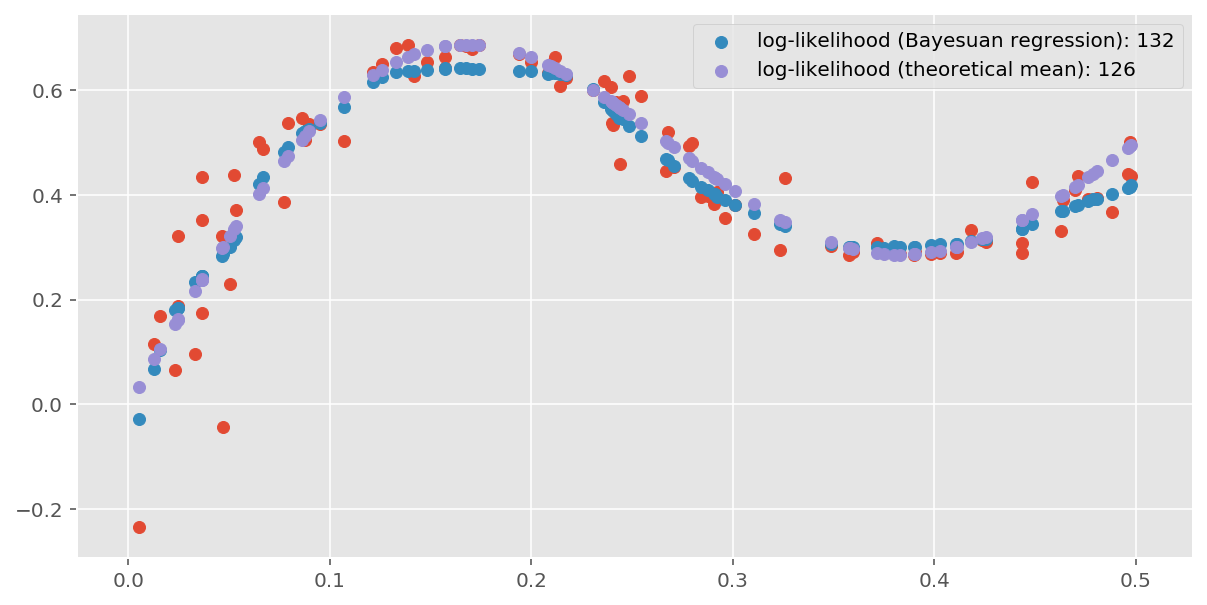

In [481]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(1000):
    y += net(reg_model.X_train) / 1000

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'log-likelihood (Bayesuan regression): {log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0), label=f'log-likelihood (theoretical mean): {log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()

## 3. Bayesian regression with Bayesian by Backpropagation

In [553]:
import models.bayesbackprop_regression as bbb

##### Definition of the model

In [584]:
prior_parameters = {'sigma1': 1, 'sigma2': np.exp(-6), 'pi': 0.5}
net = bbb.BayesBackpropNet(hidden_size=100, dim_input=1, dim_output=1, prior_parameters=prior_parameters, sigma=0.06)
reg_model = bbb.BayesBackpropReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=10)

##### Training step

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(20000, optimizer, 2, 'geometric')

   0: 295317856.000000
  50: 230608384.000000
 100: 95096744.000000
 150: 36179868.000000
 200: 37375732.000000
 250: 26116874.000000
 300: 16521228.000000
 350: 16935128.000000
 400: 11000688.000000
 450: 6066338.500000
 500: 10983530.000000
 550: 8158767.000000
 600: 3386106.500000
 650: 3533039.250000
 700: 4305662.000000
 750: 756573.500000
 800: 2158714.250000
 850: 551991.937500
 900: 508823.375000
 950: 435558.125000
1000: 267885.156250
1050: 456818.593750
1100: 111802.601562
1150: 184253.671875
1200: 144399.671875
1250: 60870.394531
1300: 43084.050781
1350: 26949.765625
1400: 42603.847656
1450: 41267.339844
1500: 27607.109375
1550: 18395.958984
1600: 46979.613281
1650: 79902.648438
1700: 23134.742188
1750: 49368.738281
1800: 17900.255859
1850: 16959.984375
1900: 19731.984375
1950: 19448.818359
2000: 22441.492188
2050: 16442.802734


##### Test step

In [579]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

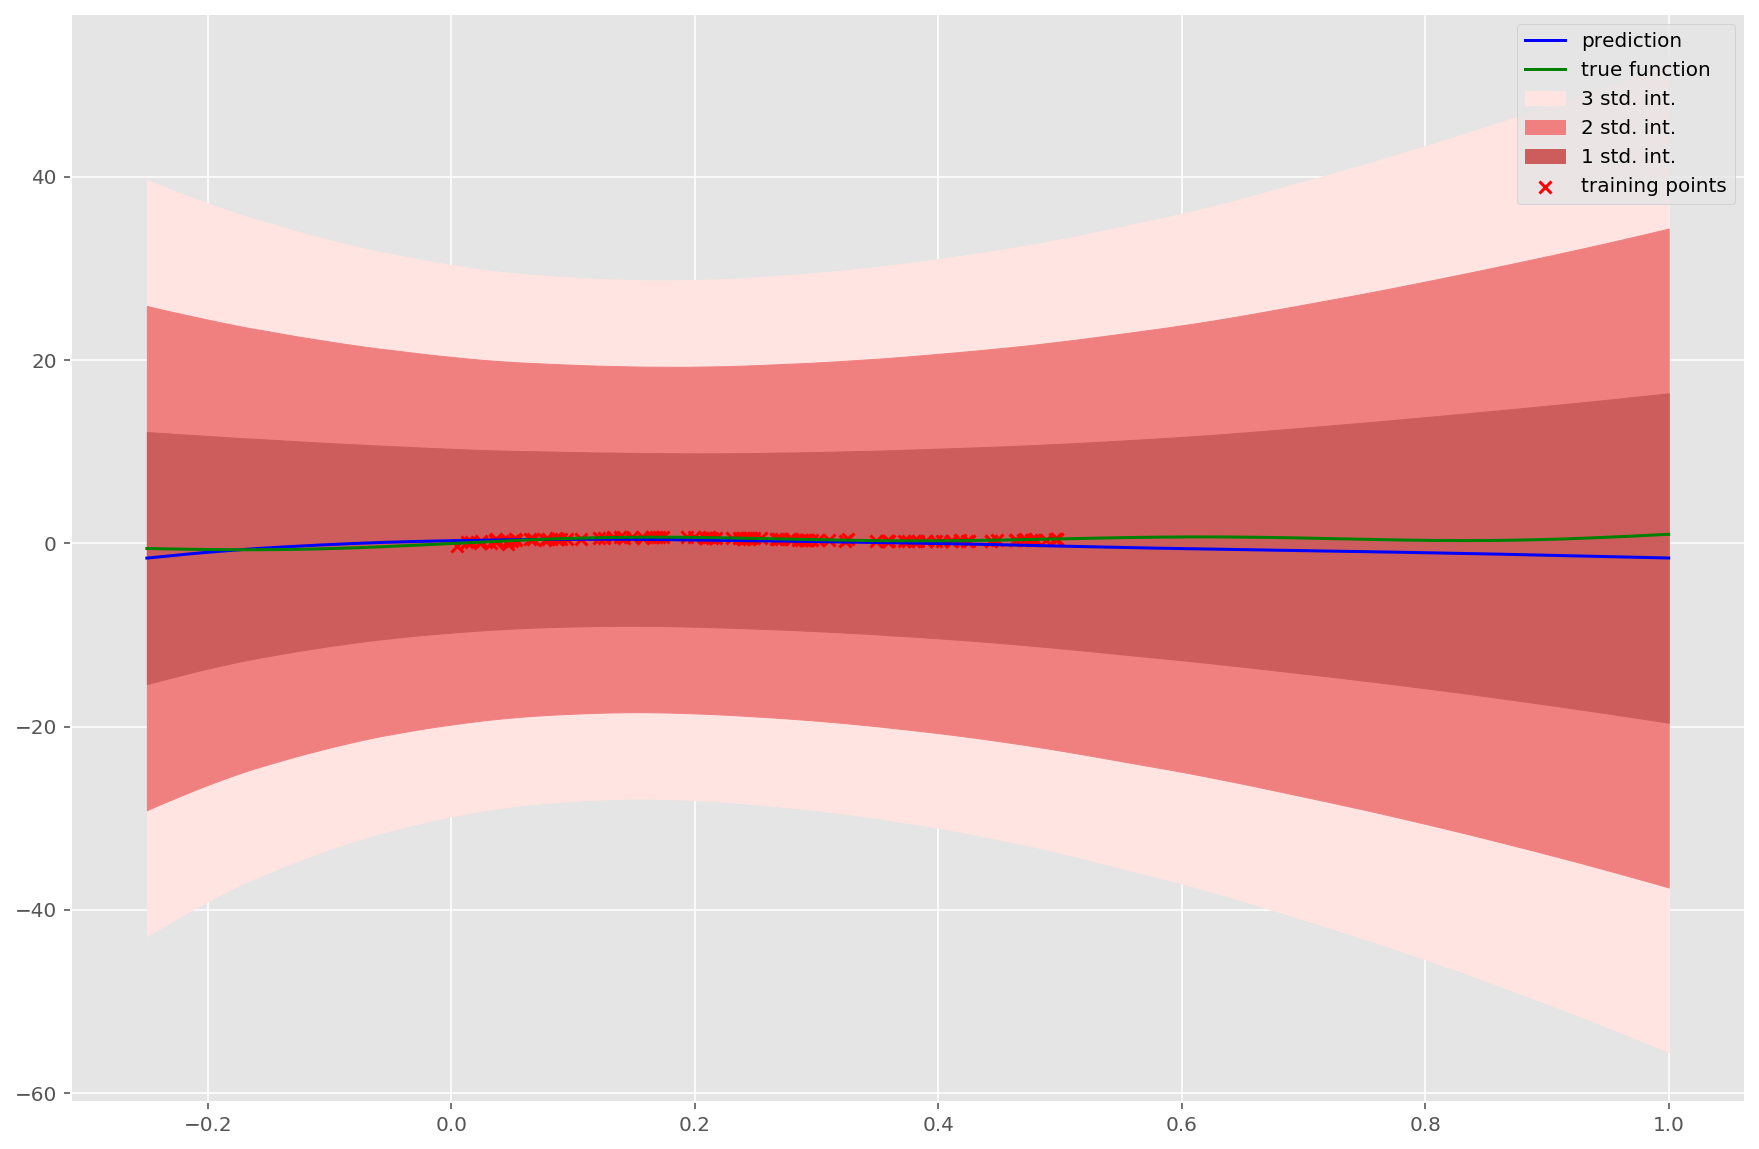

In [580]:
plt.figure(figsize=(15, 10))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.show()

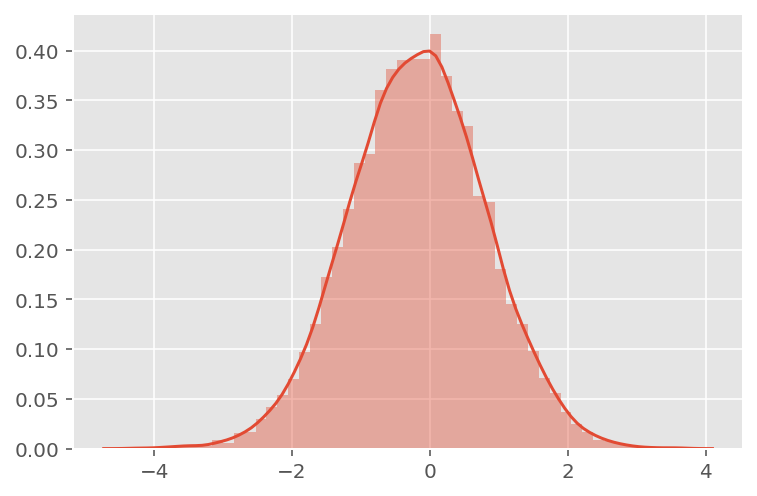

In [581]:
sns.distplot(net.weights_dist())

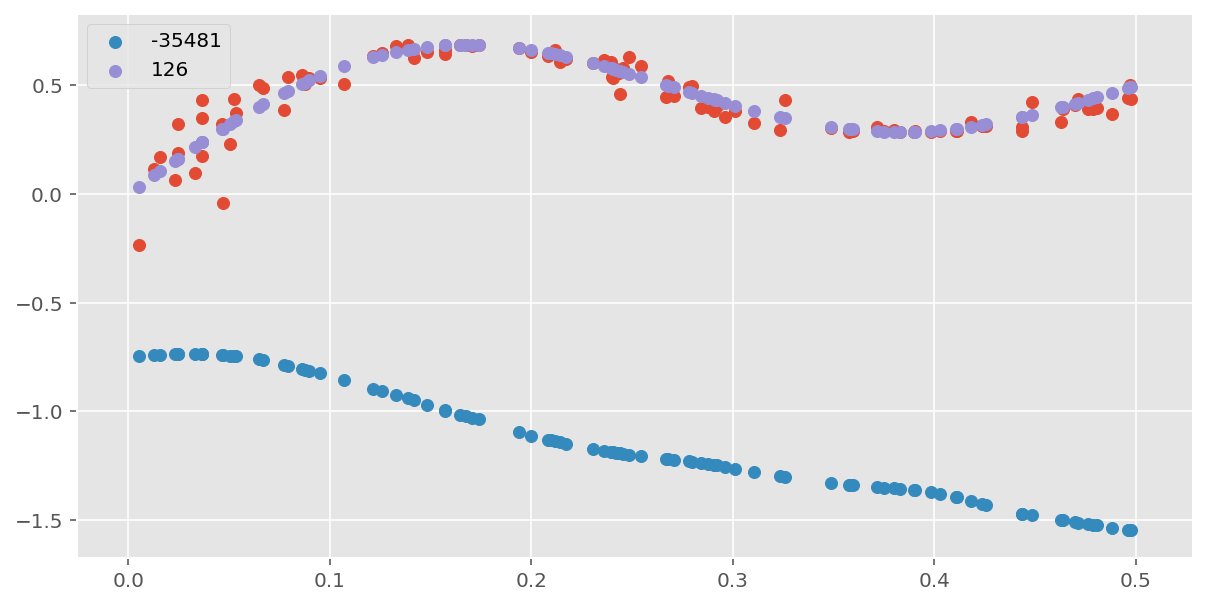

In [583]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(100):
    y += net(reg_model.X_train) / 100

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'{log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0), label=f'{log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()